# Classificazione binaria

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

In [3]:

binary_cols = ['HLTHPLN1','MEDCOST','TOLDHI2','CVDINFR4',
            'CVDCRHD4','CVDSTRK3','ASTHMA3','CHCSCNCR','CHCOCNCR',
            'CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','VETERAN3',
            'INTERNET','QLACTLM2','USEEQUIP','BLIND','DECIDE',
            'DIFFWALK','DIFFDRES','DIFFALON','SMOKE100','EXERANY2','FLUSHOT6',
            'PNEUVAC3', 'HIVTST6', 'PERSDOC2', 'BPHIGH4'] 

nominal_cols = [
    'MARITAL','EMPLOY1','_RACE', '_BMI5CAT'
]

numeric_cols = [
    'PHYSHLTH','CHILDREN',
    'ALCDAY5', 'FRUITJU1',  'STRENGTH',
    'FRUIT1', 'FVBEANS','FVGREEN',
    'FVORANG','VEGETAB1'
]

ordinal = {
    'GENHLTH':       [1,2,3,4,5],       # 1=Excellent … 5=Poor
    'CHECKUP1':      [1,2,3,4,5,6,7,8], # 
    'CHOLCHK':       [1,2,3,4],         
    '_AGE_G':        [1,2,3,4,5,6],     # 1=18–24 … 6=65+
    '_PACAT1':       [1,2,3,4],         # 1=High active … 4=Inactive     
    'EDUCA':         [1,2,3,4,5,6],     # 1=Less than high school … 6=Post-grad
    'INCOME2':       [1,2,3,4,5,6,7,8], # 1=Less than $10K … 8=$75K or more
}

# Nominali: stringa coerente
for col in nominal_cols:
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['nan', 'None', '-9223372036854775808'], np.nan)

# Ordinali: forzati a float con NaN se conversione fallisce
for col in list(ordinal.keys()):
    df[col] = pd.to_numeric(df[col], errors='coerce')


df[binary_cols] = df[binary_cols].astype('Int64')

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213674 entries, 0 to 213673
Data columns (total 51 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   GENHLTH   213480 non-null  float64
 1   PHYSHLTH  211979 non-null  float64
 2   HLTHPLN1  213570 non-null  Int64  
 3   PERSDOC2  213524 non-null  Int64  
 4   MEDCOST   213507 non-null  Int64  
 5   CHECKUP1  213063 non-null  float64
 6   BPHIGH4   213531 non-null  Int64  
 7   CHOLCHK   213049 non-null  float64
 8   TOLDHI2   213129 non-null  Int64  
 9   CVDINFR4  213232 non-null  Int64  
 10  CVDCRHD4  212736 non-null  Int64  
 11  CVDSTRK3  213424 non-null  Int64  
 12  ASTHMA3   213485 non-null  Int64  
 13  CHCSCNCR  213515 non-null  Int64  
 14  CHCOCNCR  213529 non-null  Int64  
 15  CHCCOPD1  213236 non-null  Int64  
 16  HAVARTH3  213336 non-null  Int64  
 17  ADDEPEV2  213428 non-null  Int64  
 18  CHCKIDNY  213294 non-null  Int64  
 19  DIABETE3  213674 non-null  object 
 20  MARI

In [ ]:
from sklearn.model_selection import train_test_split

y_map = {'NoDiabetes': 0, 'PreDiabetes': 1, 'Diabetes': 1}
df['DIABETE3'] = df['DIABETE3'].map(y_map)

# Definizione feature e target
X = df.drop(columns=['DIABETE3'])
y = df['DIABETE3']

# Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
X, y, stratify=y, test_size=0.3, random_state=42
)

print(y_train.value_counts())
print(y_test.value_counts())

DIABETE3
0    104377
1     34511
Name: count, dtype: int64
DIABETE3
0    56203
1    18583
Name: count, dtype: int64


# SMOTE

🔍 Valutazione modelli:  29%|██▊       | 2/7 [05:00<12:04, 144.87s/it]/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depreca

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0        Random Forest  0.802784   0.642571  0.464924  0.539500  0.835040
1  Logistic Regression  0.745766   0.492596  0.770160  0.600873  0.833097
2             AdaBoost  0.783343   0.557432  0.621541  0.587744  0.829074
3        Decision Tree  0.728479   0.456150  0.482281  0.468852  0.646081
4                  KNN  0.670720   0.412284  0.764191  0.535607  0.758582
5             Bayesian  0.712286   0.450554  0.719365  0.554078  0.777231
6              XGBoost  0.817256   0.684013  0.491698  0.572127  0.854028


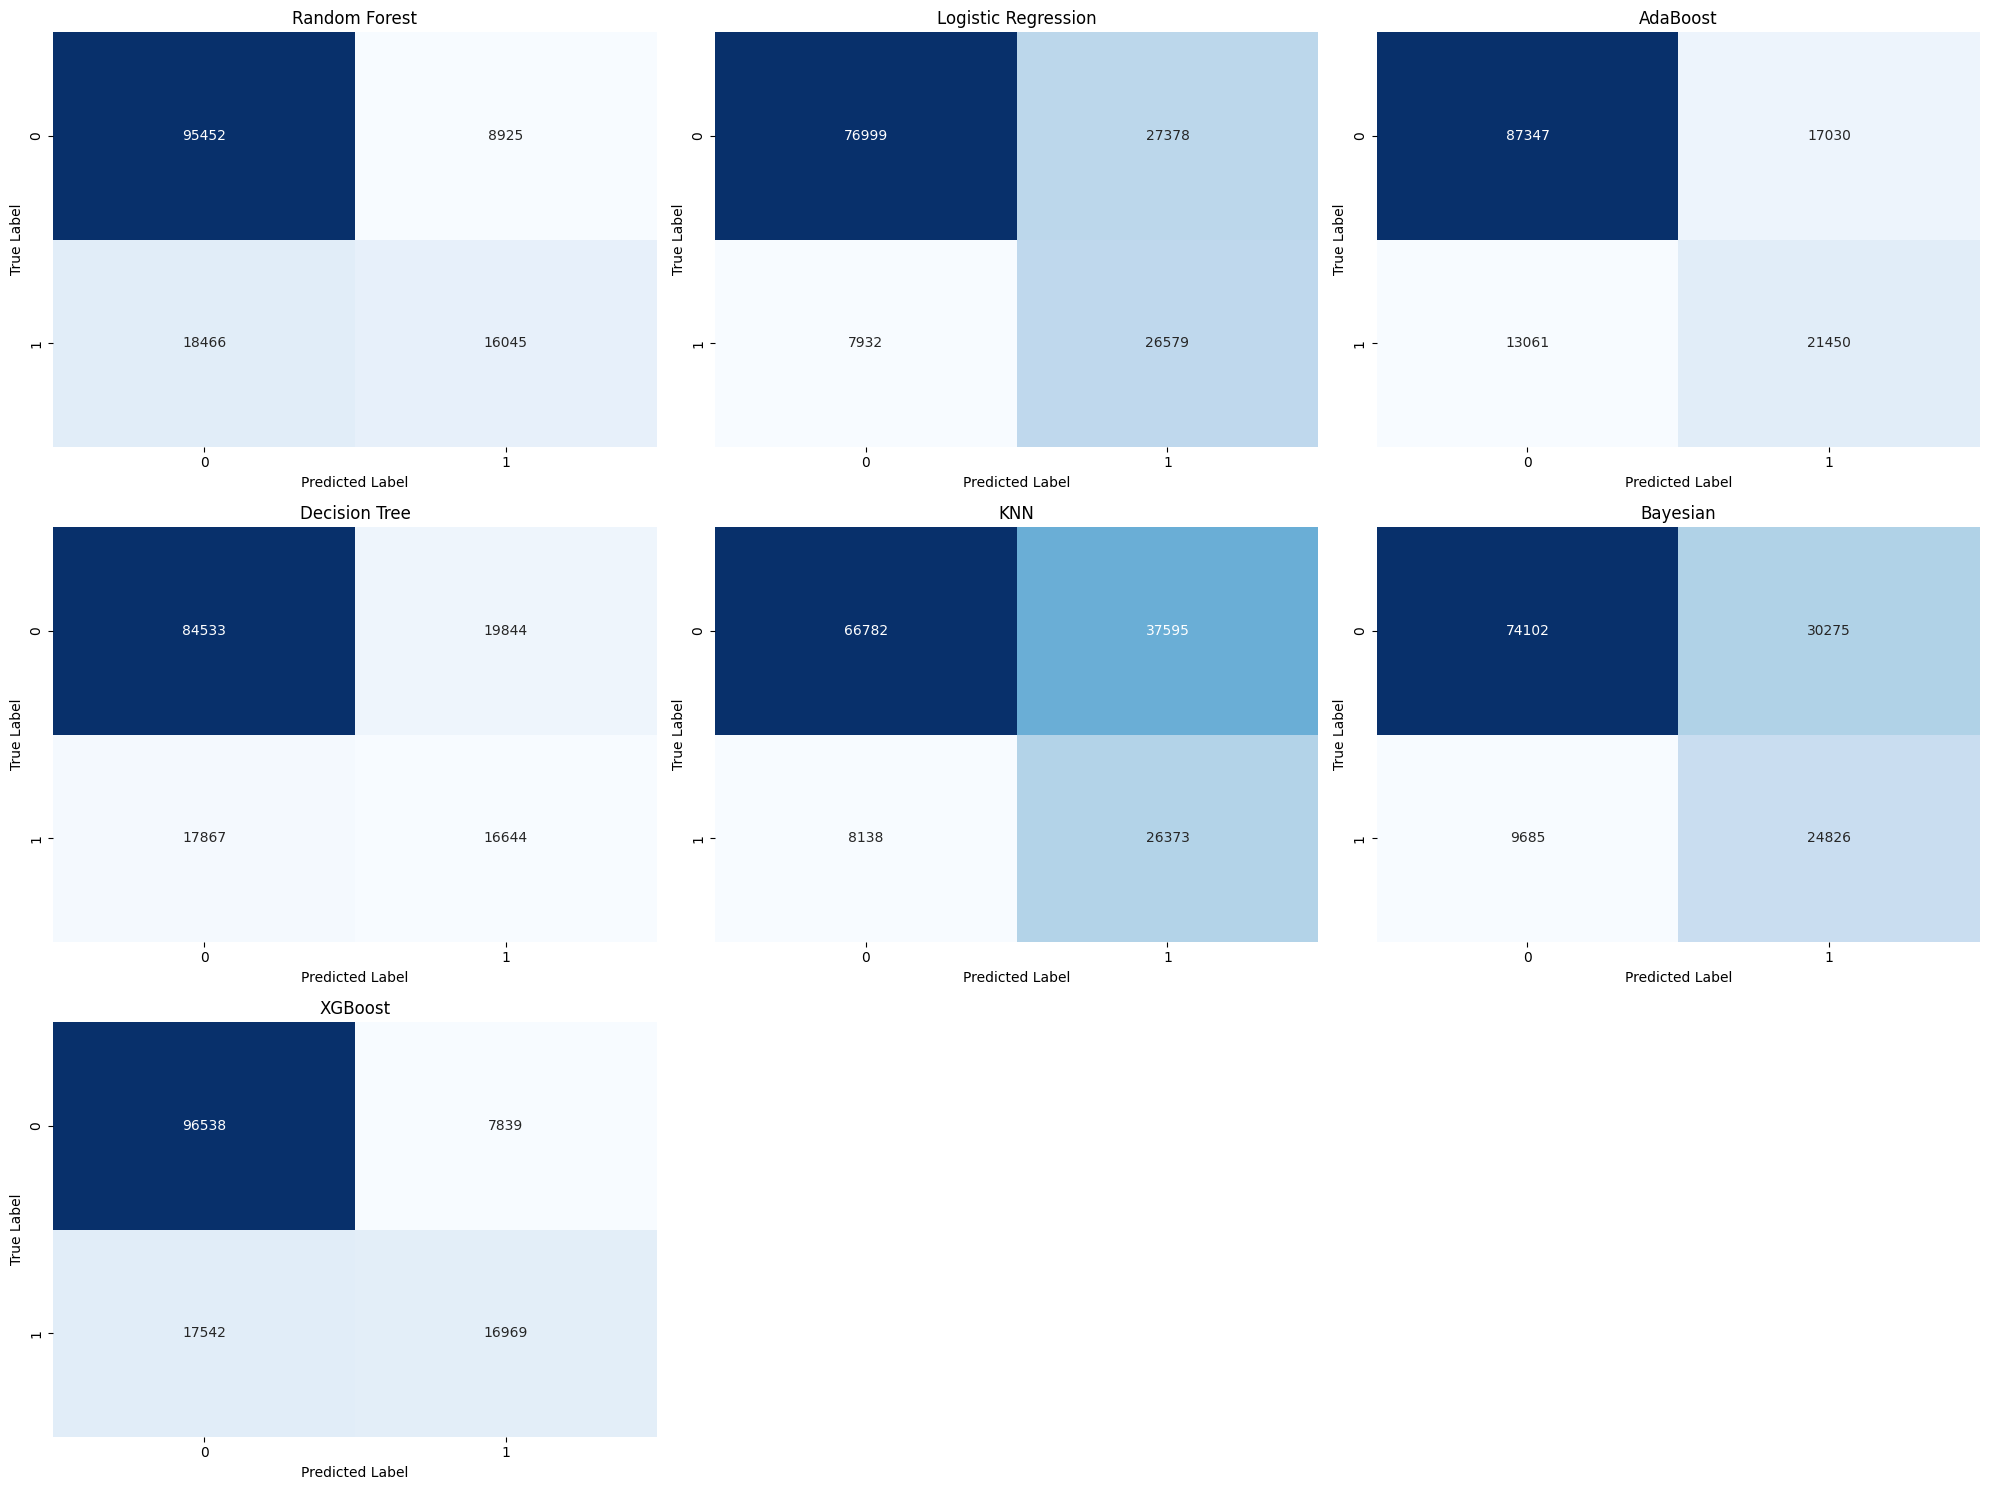

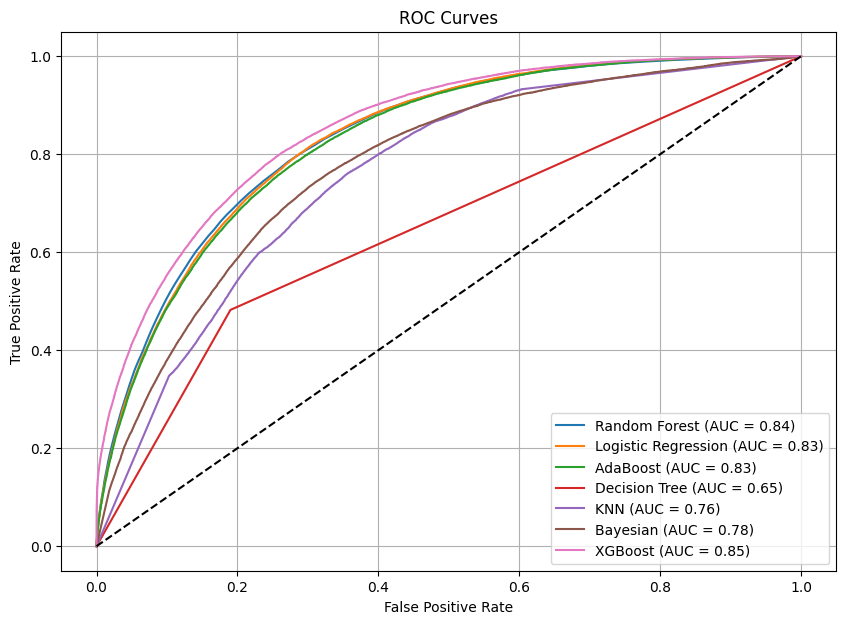

In [5]:

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm  # ✅ Aggiunto tqdm per barre di avanzamento

from prep.preprocessor import preprocessor
from prep.DiabetesFeatureEngineer import DiabetesFeatureEngineer
# === MODELLI ===
models = {
    'Random Forest': RandomForestClassifier(random_state=42,class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced',random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42,class_weight='balanced'),
    'KNN': KNeighborsClassifier(weights='distance'),
    'Bayesian': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42)
}

# === STRATIFIED CV ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_scores = {}
conf_matrices = {}
roc_curves = {}
all_results = []

# === LOOP PER MODELLO CON TQDM ===
for model_name, model in tqdm(models.items(), desc="🔍 Valutazione modelli"):

    pipeline = Pipeline(steps=[
        ('feature_engineering', DiabetesFeatureEngineer()),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    y_true = []
    y_pred = []
    y_prob = []

    # LOOP CON TQDM SUI FOLD
    for fold_idx, (train_idx, test_idx) in enumerate(tqdm(skf.split(X_train, y_train), total=5, desc=f"📂 CV {model_name}")):
        X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_fold_test,  y_fold_test  = X_train.iloc[test_idx],  y_train.iloc[test_idx]

        pipeline.fit(X_fold_train, y_fold_train)

        y_pred_fold = pipeline.predict(X_fold_test)
        y_prob_fold = pipeline.predict_proba(X_fold_test)[:, 1]

        y_true.extend(y_fold_test)
        y_pred.extend(y_pred_fold)
        y_prob.extend(y_prob_fold)

    # === METRICHE ===
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    
    all_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrices[model_name] = conf_matrix

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_curves[model_name] = (fpr, tpr)


# === RISULTATI ===
results_df = pd.DataFrame(all_results)
print(results_df)



# === CONFUSION MATRICES ===
num_models = len(models)
cols = 3
rows = num_models // cols + int(num_models % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for idx, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    ax = axes[idx]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

for idx in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# === ROC CURVES ===
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr) in roc_curves.items():
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()


In [6]:

from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from prep.preprocessor import preprocessor
from prep.DiabetesFeatureEngineer import DiabetesFeatureEngineer


pipeline = Pipeline(steps=[
        ('feature_engineering', DiabetesFeatureEngineer()),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced',random_state=42))
    ])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
})
results


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.748349,0.495905,0.772157,0.60394,0.756317


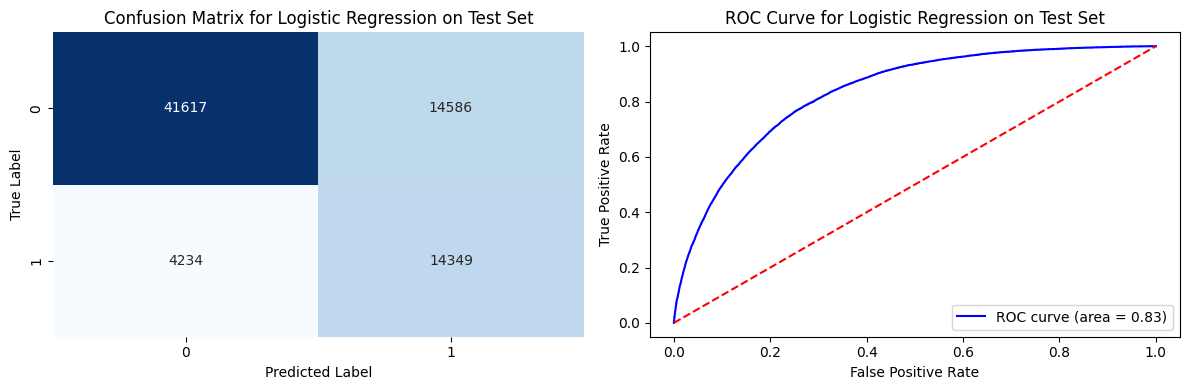

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

cm = confusion_matrix(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

# Plot the Confusion Matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix for Logistic Regression on Test Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve for Logistic Regression on Test Set')
axes[1].legend(loc="lower right")

# Show the combined plots
plt.tight_layout()
plt.show()

# GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100], # Regularization strength
    'model__solver': ['lbfgs', 'liblinear'], # Solver for optimization
    'model__class_weight': ['balanced', None], # Class weight
}

scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring,refit='recall', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best recall: ", grid_search.cv_results_['mean_test_recall'].max())
print("Best ROC AUC: ", grid_search.cv_results_['mean_test_roc_auc'].max())

Best parameters found:  {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__solver': 'liblinear'}
Best recall:  0.771058631608018
Best ROC AUC:  0.8332294858597571


In [9]:
best_params = {
    'model__C': 0.01, # Regularization strength
    'model__solver': 'liblinear', # Solver for optimization
    'model__class_weight': 'balanced' # Class weigh
}

# Define the pipeline with the best model parameters
best_pipeline = Pipeline(steps=[
        ('feature_engineering', DiabetesFeatureEngineer()),
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced',random_state=42))
    ])

# Fit the model on the training data
best_pipeline.fit(X_train, y_train)

# Predictions
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# create a dataframe to store the results
results = pd.DataFrame({
    'Model': ['Linear Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
})
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Linear Regression,0.748349,0.495905,0.772157,0.60394,0.756317


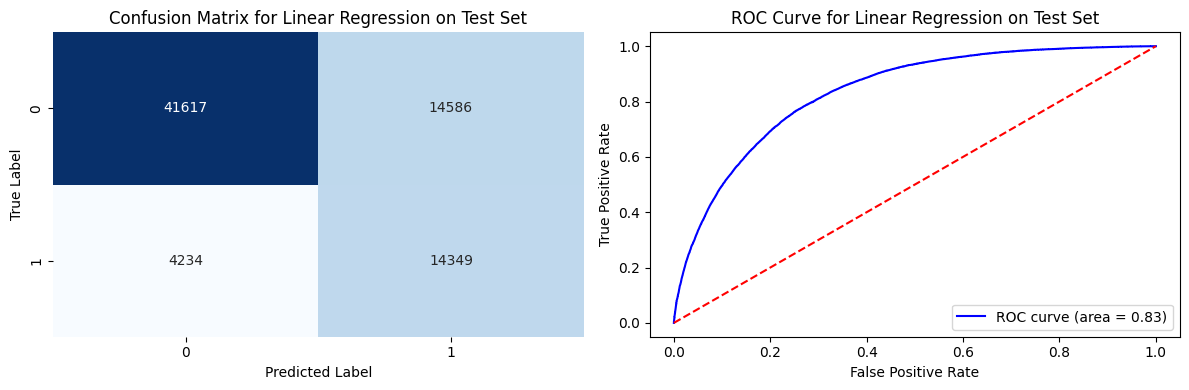

In [10]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Adjust the figsize to make it compact

# Plot the Confusion Matrix on the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'Confusion Matrix for Linear Regression on Test Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot the ROC curve on the second subplot
axes[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_value:.2f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve for Linear Regression on Test Set')
axes[1].legend(loc="lower right")

# Show the combined plots
plt.tight_layout()
plt.show()

In [11]:
binary_cols = ['HLTHPLN1','MEDCOST','TOLDHI2','CVDINFR4',
            'CVDCRHD4','CVDSTRK3','ASTHMA3','CHCSCNCR','CHCOCNCR',
            'CHCCOPD1','HAVARTH3','ADDEPEV2','CHCKIDNY','VETERAN3',
            'INTERNET','QLACTLM2','USEEQUIP','BLIND','DECIDE',
            'DIFFWALK','DIFFDRES','DIFFALON','FLUSHOT6',
            'PNEUVAC3', 'HIVTST6', 'PERSDOC2', 'BPHIGH4'] 

nominal_cols = [
    'MARITAL','EMPLOY1','_RACE', '_BMI5CAT', 'AGE_GROUP'
]

numeric_cols = [
    'PHYSHLTH','CHILDREN',
    'FRUITJU1','NutritionScore','STRENGTH'
]

ordinal = {
    'GENHLTH':       [1,2,3,4,5],       # 1=Excellent … 5=Poor
    'CHECKUP1':      [1,2,3,4,5,6,7,8], # 
    'CHOLCHK':       [1,2,3,4],         
    'EDUCA':         [1,2,3,4,5,6],     # 1=Less than high school … 6=Post-grad
    'INCOME2':       [1,2,3,4,5,6,7,8], # 1=Less than $10K … 8=$75K or more
    'Sedentary':     [0,1,2],         # 0=Active … 2=Inactive
    'RiskyBehavior': [0,1,2],         # 0=No … 2=Yes
    'LowAccess':     [0,1,2],         # 0=No … 2=Yes
    
}

# Feature Importance

In [12]:
# Estrai il modello dalla pipeline
model = best_pipeline.named_steps['model']
importance = np.abs(model.coef_)[0]  # usa il valore assoluto del coefficiente
# Estrai il preprocessor
preprocessor = best_pipeline.named_steps['preprocessing']
# 1. Nomi delle feature numeriche (trasformate ma non codificate)
numerical_features = numeric_cols
# 2. Nomi delle feature binarie (non trasformate)
binary_features = binary_cols
# 3. Nomi delle feature nominali (OneHot codificate)
onehot_encoder = preprocessor.named_transformers_['nom'].named_steps['onehot']
nominal_feature_names = onehot_encoder.get_feature_names_out(nominal_cols)
# 4. Nomi delle feature ordinali (OrdinalEncoder)
ordinal_features = list(ordinal.keys())
# 5. Combina tutti i nomi delle feature nell’ordine usato da ColumnTransformer
all_feature_names = (
    numerical_features +     # num
    binary_features +        # bin
    list(nominal_feature_names) +  # nom
    ordinal_features         # ord
)

# 🔍 Verifica consistenza lunghezza
assert len(all_feature_names) == len(importance), "Mismatch tra feature names e importanze!"

# 6. Crea DataFrame con feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 7. Visualizza
feature_importance_df.head(25)


,Feature,Importance
0,_BMI5CAT_1.0,1.068237
1,AGE_GROUP_Young,0.853943
2,_BMI5CAT_4.0,0.715650
3,BPHIGH4,0.692440
4,GENHLTH,0.618758
5,CHOLCHK,0.575954
6,MEDCOST,0.553305
7,TOLDHI2,0.542151
8,_BMI5CAT_2.0,0.521505
9,PNEUVAC3,0.518542


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


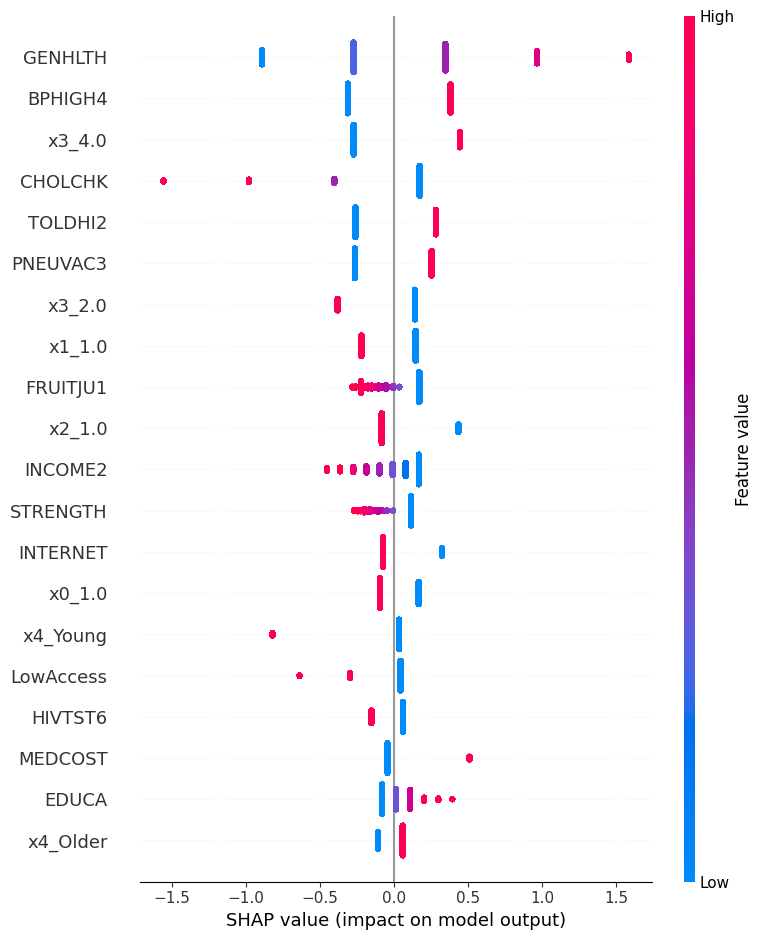

In [15]:
import shap


def plot_shap_logistic_binary(pipeline, X_sample, top_n=20, instance_index=None):
    """
    Calcola e visualizza i valori SHAP per un modello LogisticRegression binario.

    Args:
        pipeline: Pipeline sklearn con preprocessing + LogisticRegression
        X_sample: DataFrame (non preprocessato)
        top_n: quante feature visualizzare nel summary plot
        instance_index: se specificato, mostra waterfall plot per quella istanza
    """
    model = pipeline.named_steps['model']
    preprocessor = pipeline.named_steps['preprocessing']
    feature_engineer = pipeline.named_steps.get('feature_engineering', None)

    # Applica feature engineering e preprocessing
    if feature_engineer:
        X_fe = feature_engineer.transform(X_sample)
    else:
        X_fe = X_sample.copy()

    X_proc = preprocessor.transform(X_fe)

    # Recupera nomi delle feature trasformate
    num = preprocessor.transformers_[0][2]
    bin = preprocessor.transformers_[1][2]
    nominal = preprocessor.named_transformers_['nom'].named_steps['onehot'].get_feature_names_out()
    ordn = preprocessor.transformers_[3][2]
    feature_names = list(num) + list(bin) + list(nominal) + list(ordn)

    # Crea LinearExplainer per modello lineare binario
    explainer = shap.LinearExplainer(model, X_proc, feature_perturbation="interventional", feature_names=feature_names)
    shap_values = explainer(X_proc)

    # summary plot
    shap.summary_plot(shap_values.values, X_proc, feature_names=feature_names, max_display=top_n)

    # waterfall plot (opzionale)
    if instance_index is not None:
        shap.plots.waterfall(shap.Explanation(
            values=shap_values.values[instance_index],
            base_values=shap_values.base_values[instance_index],
            data=X_proc[instance_index],
            feature_names=feature_names
        ))
        

plot_shap_logistic_binary(best_pipeline, X_test)


In [13]:

import pickle

# Save the trained model as a pickle file
with open('diabetes_classifier.pkl', 'wb') as model_file:
    pickle.dump(best_pipeline, model_file)